# PCA with Scikit-learn on Real Datasets

**Author**: Nelson Masbayi

---

In this notebook, I apply PCA to real-world datasets using scikit-learn, starting with the classic Iris dataset then exploring high-dimensional datasets.

## Table of Contents

1. [Iris Dataset Analysis](#iris-dataset-analysis)
2. [Component Interpretation](#component-interpretation)
3. [Scree Plot Analysis](#scree-plot-analysis)
4. [High-Dimensional Dataset Analysis](#high-dimensional-dataset-analysis)
5. [Practical Insights](#practical-insights)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, fetch_olivetti_faces, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src directory to the path for our utilities
sys.path.append('../src')
from visualization_utils import plot_2d_pca_results, compare_pca_implementations

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# Set random seed
np.random.seed(42)

print("✅ All imports successful!")
print(f"Scikit-learn PCA ready for real-world data analysis")

✅ All imports successful!
Scikit-learn PCA ready for real-world data analysis


## Iris Dataset Analysis

The Iris dataset is perfect for PCA analysis as it has:
- 4 continuous features (sepal/petal length/width)
- 3 well-separated classes
- Known biological relationships between features
- Small size for easy interpretation

In [2]:
# Load the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Iris Dataset Information:")
print(f"Data shape: {X_iris.shape}")
print(f"Features: {feature_names}")
print(f"Classes: {target_names}")
print(f"Class distribution: {np.bincount(y_iris)}")

# Display basic statistics
iris_df = pd.DataFrame(X_iris, columns=feature_names)
iris_df['species'] = [target_names[i] for i in y_iris]

print("\nBasic Statistics:")
print(iris_df.describe())

# Check for missing values
print(f"\nMissing values: {iris_df.isnull().sum().sum()}")
print(f"Data types: {iris_df.dtypes.unique()}")

Iris Dataset Information:
Data shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
Class distribution: [50 50 50]

Basic Statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000

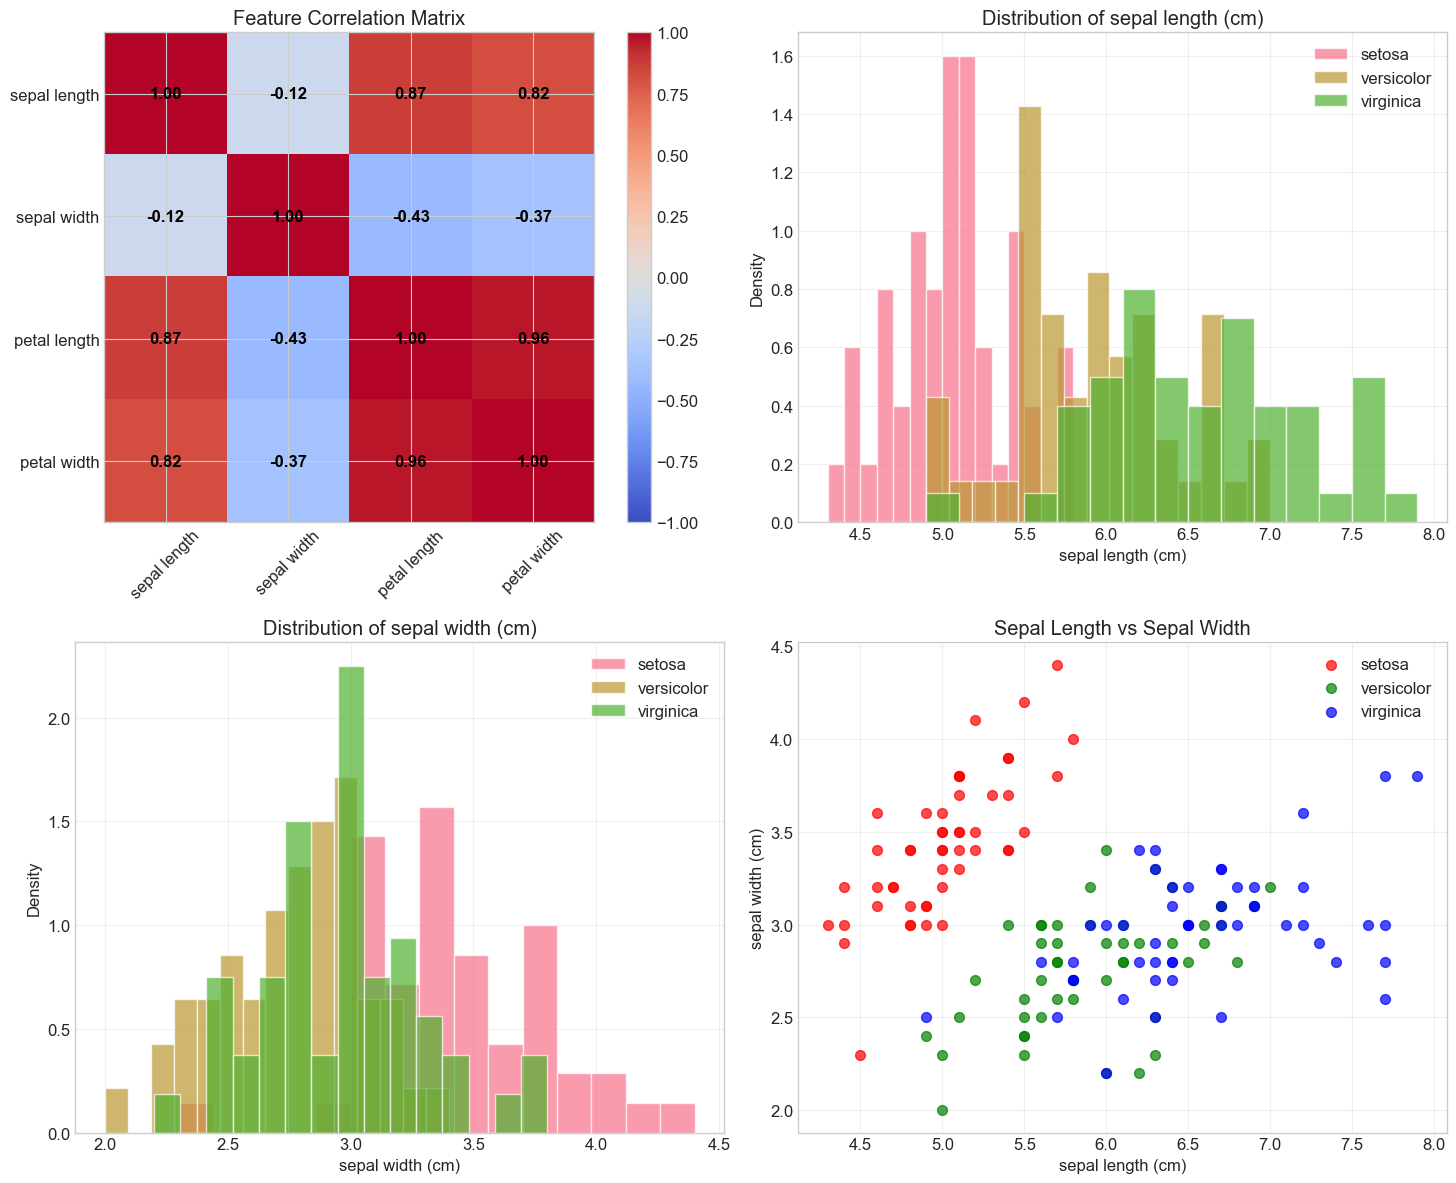

Key Observations:
• Highest correlation: 0.963
• Features show clear class separations
• Petal measurements likely more discriminative than sepal measurements


In [3]:
# Explore the data with pairwise plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Raw data correlation matrix
correlation_matrix = np.corrcoef(X_iris.T)
im = axes[0, 0].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[0, 0].set_title('Feature Correlation Matrix')
axes[0, 0].set_xticks(range(len(feature_names)))
axes[0, 0].set_yticks(range(len(feature_names)))
axes[0, 0].set_xticklabels([name.replace(' (cm)', '') for name in feature_names], rotation=45)
axes[0, 0].set_yticklabels([name.replace(' (cm)', '') for name in feature_names])

# Add correlation values
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        text = axes[0, 0].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[0, 0])

# Feature distributions by class
for idx, feature_idx in enumerate([0, 1]):  # First two features
    ax = axes[0, 1] if idx == 0 else axes[1, 0]

    for class_idx, class_name in enumerate(target_names):
        class_data = X_iris[y_iris == class_idx, feature_idx]
        ax.hist(class_data, bins=15, alpha=0.7, label=class_name, density=True)

    ax.set_title(f'Distribution of {feature_names[feature_idx]}')
    ax.set_xlabel(feature_names[feature_idx])
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Scatter plot of first two features
colors = ['red', 'green', 'blue']
for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
    class_mask = y_iris == class_idx
    axes[1, 1].scatter(X_iris[class_mask, 0], X_iris[class_mask, 1],
                      c=color, label=class_name, alpha=0.7, s=50)

axes[1, 1].set_title('Sepal Length vs Sepal Width')
axes[1, 1].set_xlabel(feature_names[0])
axes[1, 1].set_ylabel(feature_names[1])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print(f"• Highest correlation: {np.max(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]):.3f}")
print(f"• Features show clear class separations")
print(f"• Petal measurements likely more discriminative than sepal measurements")

### Data Standardization Decision

Analyze the importance of data standardization:

Feature Scale Analysis:

Feature Means:
sepal length (cm): 5.84
sepal width (cm): 3.06
petal length (cm): 3.76
petal width (cm): 1.20

Feature Standard Deviations:
sepal length (cm): 0.83
sepal width (cm): 0.43
petal length (cm): 1.76
petal width (cm): 0.76

Feature Ranges:
sepal length (cm): [4.3, 7.9]
sepal width (cm): [2.0, 4.4]
petal length (cm): [1.0, 6.9]
petal width (cm): [0.1, 2.5]


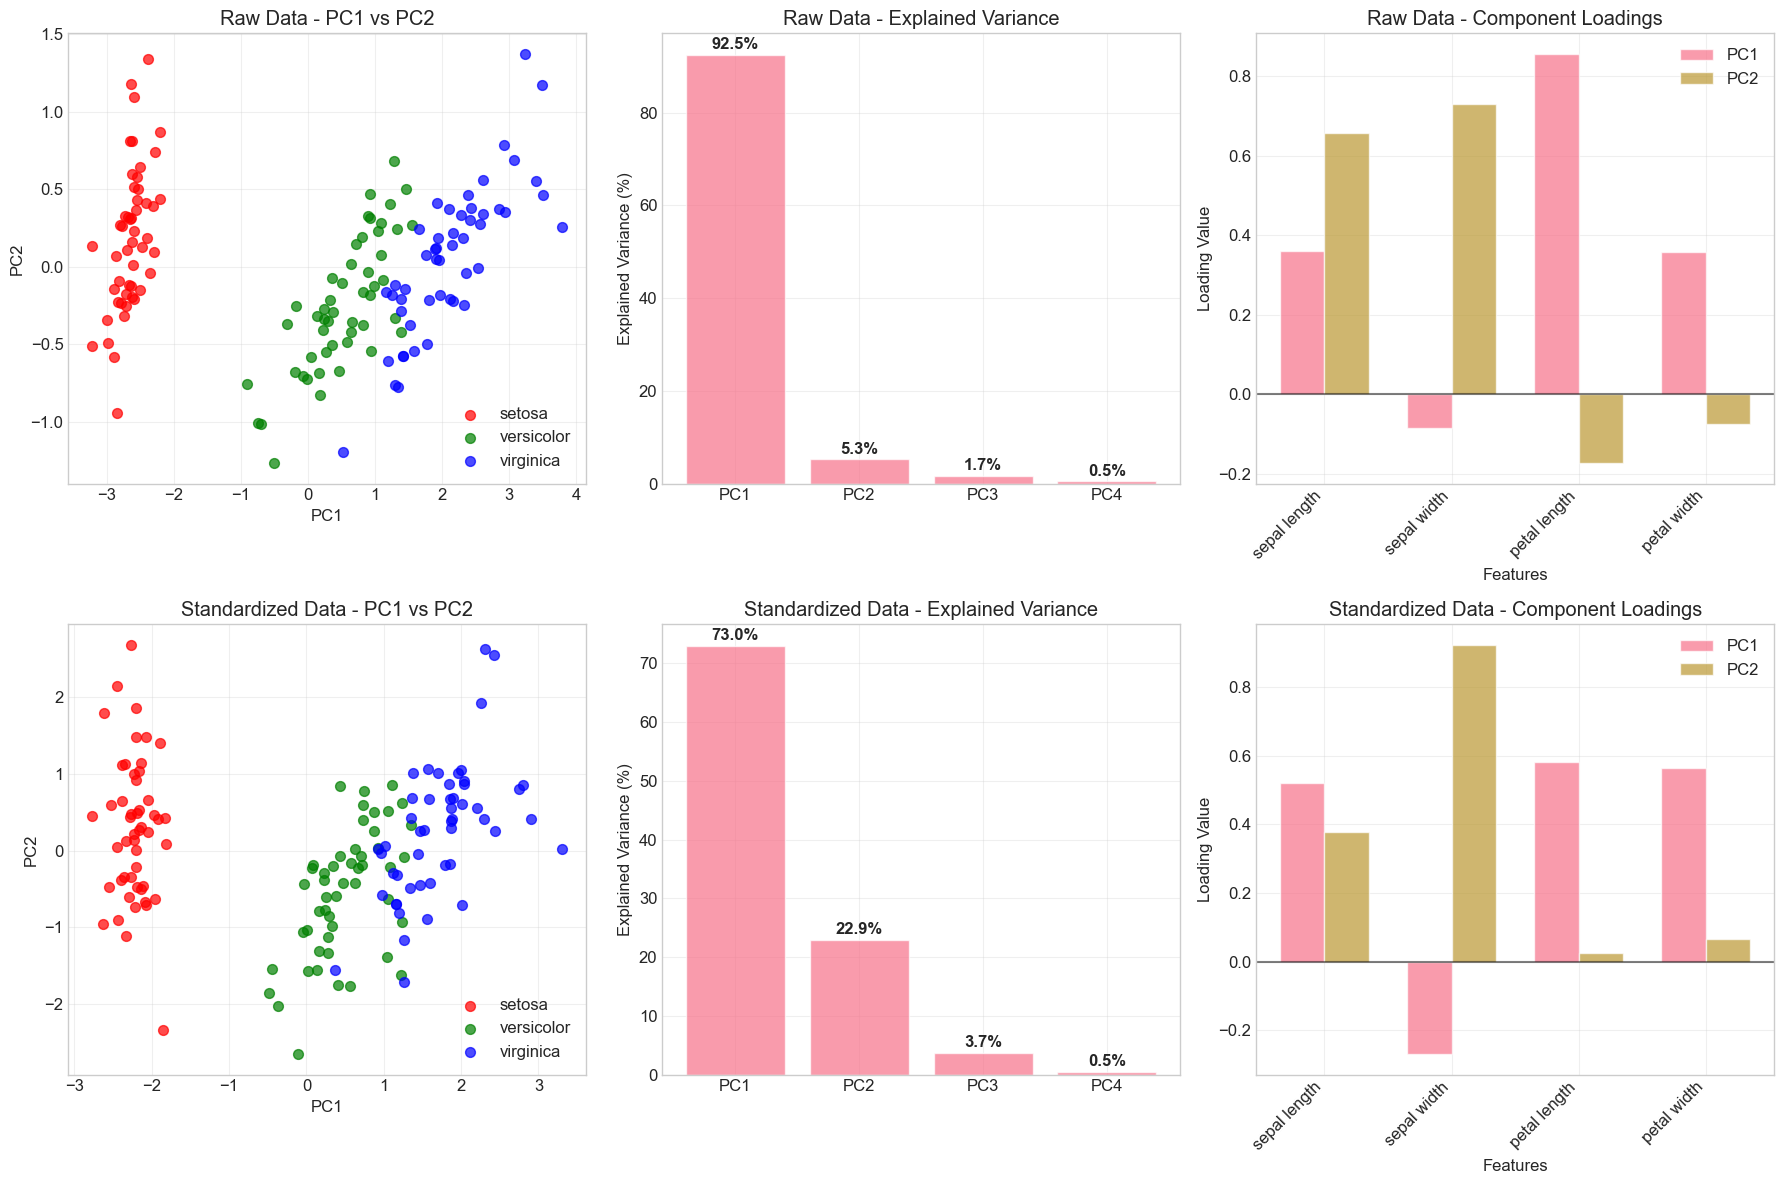


Standardization Impact:
Raw data - PC1 explains: 92.5%
Standardized - PC1 explains: 73.0%

Recommendation: Use standardized data for more balanced component contributions


In [4]:
# Analyze the need for standardization
print("Feature Scale Analysis:")
print("\nFeature Means:")
for i, name in enumerate(feature_names):
    print(f"{name}: {np.mean(X_iris[:, i]):.2f}")

print("\nFeature Standard Deviations:")
for i, name in enumerate(feature_names):
    print(f"{name}: {np.std(X_iris[:, i]):.2f}")

print("\nFeature Ranges:")
for i, name in enumerate(feature_names):
    print(f"{name}: [{np.min(X_iris[:, i]):.1f}, {np.max(X_iris[:, i]):.1f}]")

# Compare PCA results with and without standardization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Without standardization
pca_raw = PCA(n_components=4)
X_pca_raw = pca_raw.fit_transform(X_iris)

# With standardization
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
pca_scaled = PCA(n_components=4)
X_pca_scaled = pca_scaled.fit_transform(X_iris_scaled)

# Plot results
scenarios = [('Raw Data', X_pca_raw, pca_raw), ('Standardized Data', X_pca_scaled, pca_scaled)]

for row, (title, X_transformed, pca_obj) in enumerate(scenarios):
    # 2D projection
    colors = ['red', 'green', 'blue']
    for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
        class_mask = y_iris == class_idx
        axes[row, 0].scatter(X_transformed[class_mask, 0], X_transformed[class_mask, 1],
                           c=color, label=class_name, alpha=0.7, s=50)

    axes[row, 0].set_title(f'{title} - PC1 vs PC2')
    axes[row, 0].set_xlabel('PC1')
    axes[row, 0].set_ylabel('PC2')
    axes[row, 0].legend()
    axes[row, 0].grid(True, alpha=0.3)

    # Explained variance
    components = [f'PC{i+1}' for i in range(4)]
    bars = axes[row, 1].bar(components, pca_obj.explained_variance_ratio_ * 100, alpha=0.7)
    axes[row, 1].set_title(f'{title} - Explained Variance')
    axes[row, 1].set_ylabel('Explained Variance (%)')
    axes[row, 1].grid(True, alpha=0.3)

    # Add percentage labels
    for bar, percentage in zip(bars, pca_obj.explained_variance_ratio_ * 100):
        axes[row, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                         f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Component loadings
    loadings = pca_obj.components_[:2].T  # First two components
    feature_names_short = [name.replace(' (cm)', '') for name in feature_names]

    x = np.arange(len(feature_names_short))
    width = 0.35

    bars1 = axes[row, 2].bar(x - width/2, loadings[:, 0], width,
                            label='PC1', alpha=0.7, color='C0')
    bars2 = axes[row, 2].bar(x + width/2, loadings[:, 1], width,
                            label='PC2', alpha=0.7, color='C1')

    axes[row, 2].set_title(f'{title} - Component Loadings')
    axes[row, 2].set_xlabel('Features')
    axes[row, 2].set_ylabel('Loading Value')
    axes[row, 2].set_xticks(x)
    axes[row, 2].set_xticklabels(feature_names_short, rotation=45, ha='right')
    axes[row, 2].legend()
    axes[row, 2].grid(True, alpha=0.3)
    axes[row, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nStandardization Impact:")
print(f"Raw data - PC1 explains: {pca_raw.explained_variance_ratio_[0]*100:.1f}%")
print(f"Standardized - PC1 explains: {pca_scaled.explained_variance_ratio_[0]*100:.1f}%")
print(f"\nRecommendation: Use standardized data for more balanced component contributions")

## Component Interpretation

Interpreting what the principal components represent:

In [12]:
# Use standardized data for detailed analysis
pca_iris = PCA(n_components=4)
X_iris_pca = pca_iris.fit_transform(X_iris_scaled) # Also try with X_iris

print("Detailed Principal Component Analysis:")
print(f"Total components: {pca_iris.n_components_}")
print(f"Explained variance ratios: {pca_iris.explained_variance_ratio_}")
print(f"Cumulative variance: {np.cumsum(pca_iris.explained_variance_ratio_)}")

# Component interpretation
component_interpretations = []
feature_names_short = [name.replace(' (cm)', '').replace('sepal ', 'Sep.').replace('petal ', 'Pet.') for name in feature_names]

print("\nComponent Interpretation:")
for i in range(4):
    loadings = pca_iris.components_[i]

    # Find dominant features
    abs_loadings = np.abs(loadings)
    dominant_indices = np.argsort(abs_loadings)[::-1]

    print(f"\nPC{i+1} ({pca_iris.explained_variance_ratio_[i]*100:.1f}% variance):")

    interpretation = ""
    for j in dominant_indices[:2]:  # Top 2 features
        direction = "positively" if loadings[j] > 0 else "negatively"
        print(f"  • {feature_names[j]} ({direction}, loading: {loadings[j]:.3f})")
        interpretation += f"{feature_names_short[j]}({'+' if loadings[j] > 0 else '-'}) "

    component_interpretations.append(interpretation.strip())

    # Biological interpretation
    if i == 0:
        print(f"  → Interpretation: Overall flower size (all measurements contribute positively)")
    elif i == 1:
        if abs(loadings[0]) > abs(loadings[2]):  # Sepal vs Petal contrast
            print(f"  → Interpretation: Sepal vs Petal size contrast")
        else:
            print(f"  → Interpretation: Length vs Width contrast")
    elif i == 2:
        print(f"  → Interpretation: Subtle shape variations")
    else:
        print(f"  → Interpretation: Residual variation (likely noise)")

Detailed Principal Component Analysis:
Total components: 4
Explained variance ratios: [0.72962445 0.22850762 0.03668922 0.00517871]
Cumulative variance: [0.72962445 0.95813207 0.99482129 1.        ]

Component Interpretation:

PC1 (73.0% variance):
  • petal length (cm) (positively, loading: 0.580)
  • petal width (cm) (positively, loading: 0.565)
  → Interpretation: Overall flower size (all measurements contribute positively)

PC2 (22.9% variance):
  • sepal width (cm) (positively, loading: 0.923)
  • sepal length (cm) (positively, loading: 0.377)
  → Interpretation: Sepal vs Petal size contrast

PC3 (3.7% variance):
  • sepal length (cm) (positively, loading: 0.720)
  • petal width (cm) (negatively, loading: -0.634)
  → Interpretation: Subtle shape variations

PC4 (0.5% variance):
  • petal length (cm) (positively, loading: 0.801)
  • petal width (cm) (negatively, loading: -0.524)
  → Interpretation: Residual variation (likely noise)


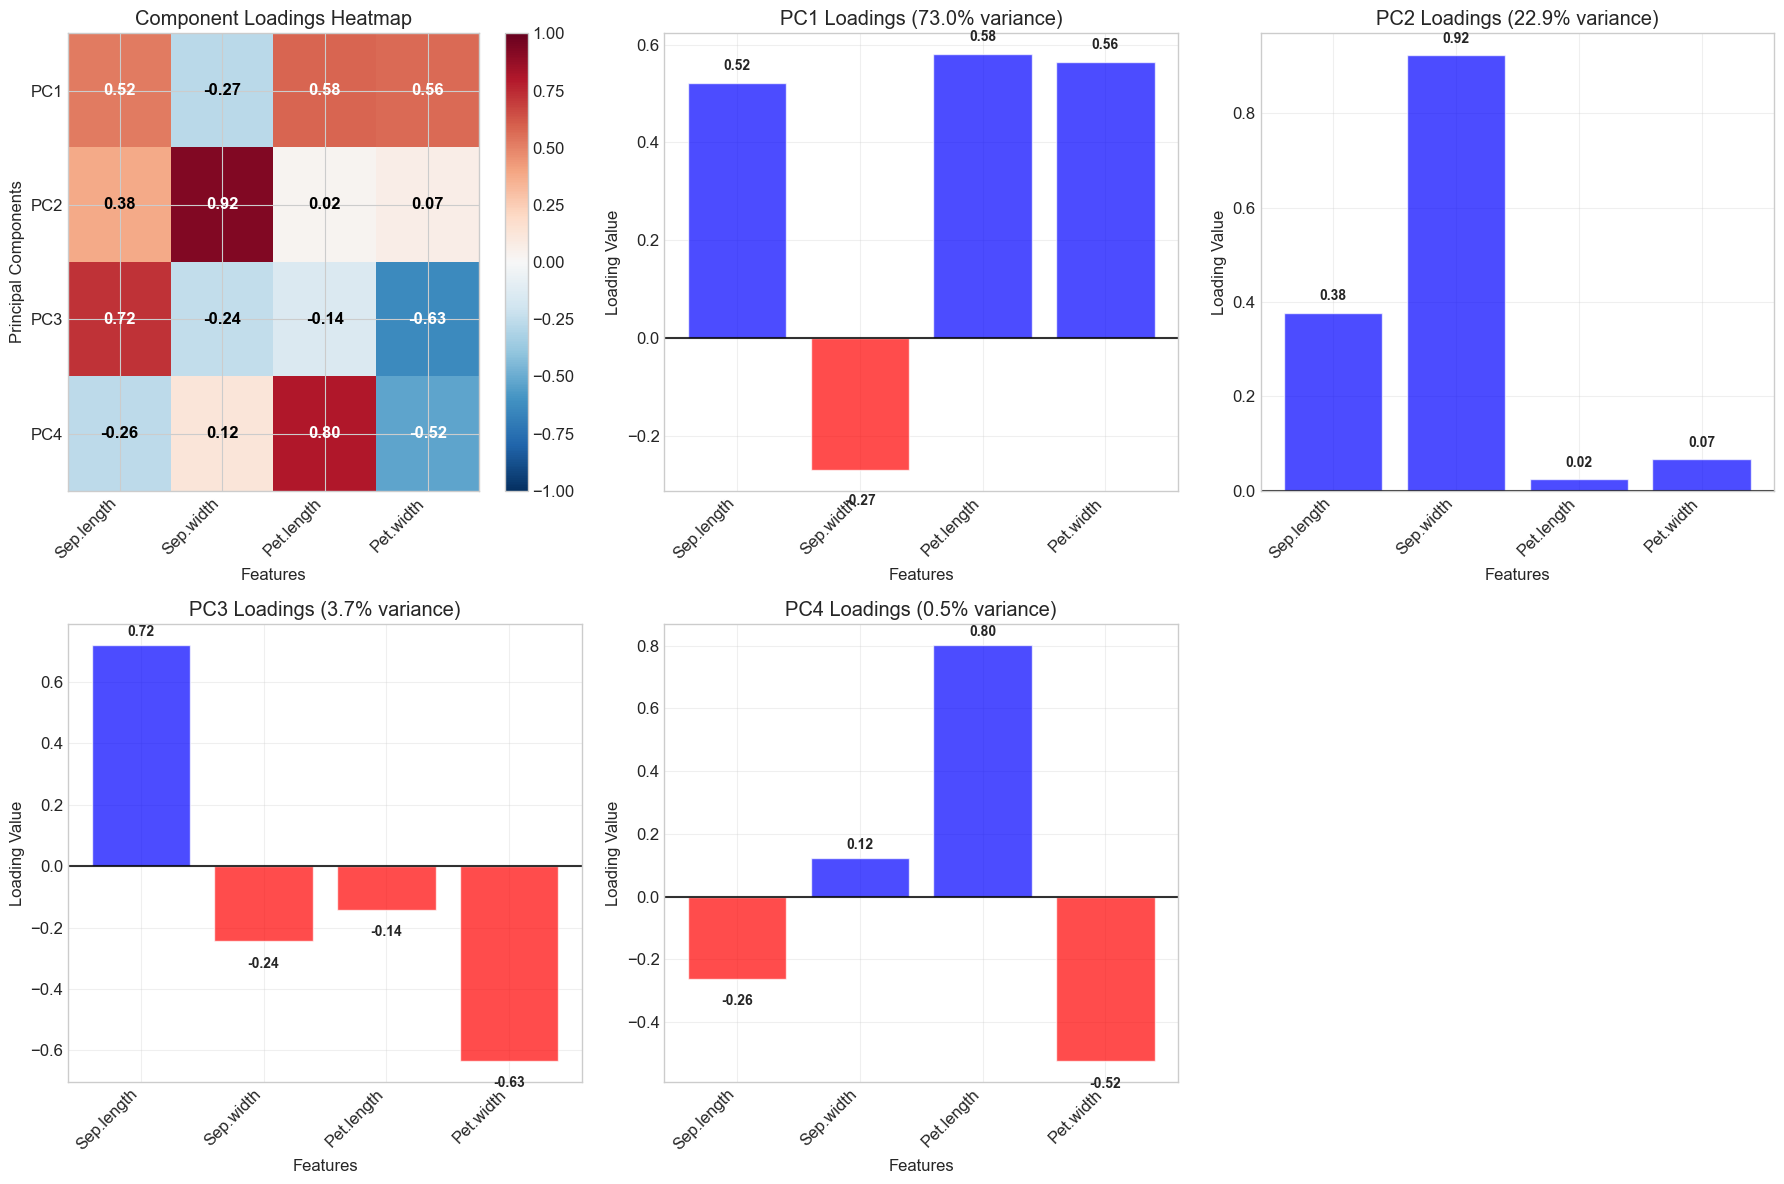

In [13]:
# Create comprehensive visualization of component loadings
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Loadings heatmap
loadings_matrix = pca_iris.components_
im = axes[0, 0].imshow(loadings_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0, 0].set_title('Component Loadings Heatmap')
axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Principal Components')
axes[0, 0].set_xticks(range(len(feature_names_short)))
axes[0, 0].set_yticks(range(4))
axes[0, 0].set_xticklabels(feature_names_short, rotation=45, ha='right')
axes[0, 0].set_yticklabels([f'PC{i+1}' for i in range(4)])

# Add loading values
for i in range(4):
    for j in range(len(feature_names)):
        text = axes[0, 0].text(j, i, f'{loadings_matrix[i, j]:.2f}',
                             ha="center", va="center",
                             color="white" if abs(loadings_matrix[i, j]) > 0.5 else "black",
                             fontweight='bold')

plt.colorbar(im, ax=axes[0, 0])

# Individual component loadings
for i in range(4):
    ax_idx = (i // 2, (i % 2) + 1) if i < 2 else ((i // 2), (i % 2) - 1)
    if i >= 2:
        ax_idx = (1, i - 2)

    ax = axes[ax_idx]

    loadings = pca_iris.components_[i]
    colors = ['red' if load < 0 else 'blue' for load in loadings]

    bars = ax.bar(range(len(feature_names_short)), loadings, color=colors, alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings ({pca_iris.explained_variance_ratio_[i]*100:.1f}% variance)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Loading Value')
    ax.set_xticks(range(len(feature_names_short)))
    ax.set_xticklabels(feature_names_short, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.8)

    # Add value labels
    for bar, value in zip(bars, loadings):
        ax.text(bar.get_x() + bar.get_width()/2,
               value + (0.02 if value >= 0 else -0.05),
               f'{value:.2f}', ha='center',
               va='bottom' if value >= 0 else 'top',
               fontsize=10, fontweight='bold')

# Remove empty subplot
if len(axes.flat) > 5:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

## Scree Plot Analysis

The scree plot helps determine the optimal number of components:

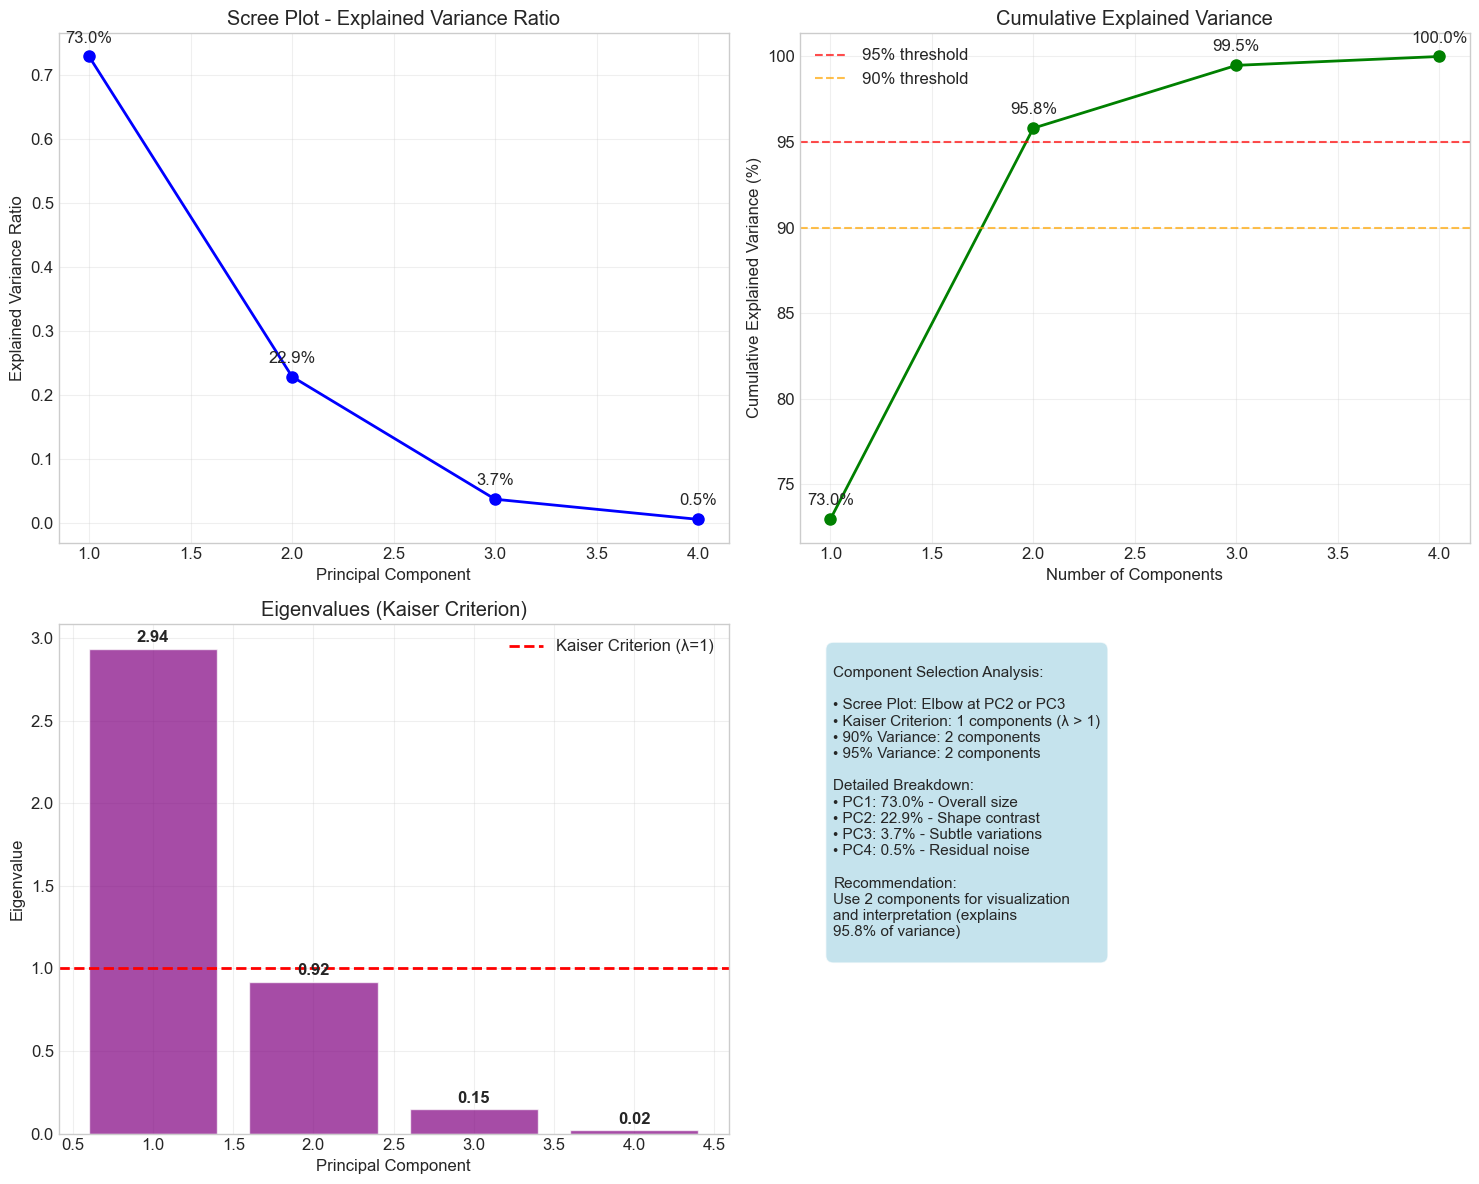

Component Selection Criteria Results:
Kaiser Criterion (eigenvalue > 1): 1 components
90% variance threshold: 2 components
95% variance threshold: 2 components

First 2 components capture 95.8% of total variance
Adding PC3 increases to 99.5% (+3.7%)


In [14]:
# Create comprehensive scree plot analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Traditional scree plot
components = range(1, len(pca_iris.explained_variance_ratio_) + 1)
axes[0, 0].plot(components, pca_iris.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Scree Plot - Explained Variance Ratio')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Add percentage labels
for i, (comp, var) in enumerate(zip(components, pca_iris.explained_variance_ratio_)):
    axes[0, 0].annotate(f'{var*100:.1f}%', (comp, var),
                       textcoords="offset points", xytext=(0,10), ha='center')

# Cumulative explained variance
cumulative_var = np.cumsum(pca_iris.explained_variance_ratio_)
axes[0, 1].plot(components, cumulative_var * 100, 'go-', linewidth=2, markersize=8)
axes[0, 1].axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
axes[0, 1].axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Add percentage labels
for i, (comp, cum_var) in enumerate(zip(components, cumulative_var)):
    axes[0, 1].annotate(f'{cum_var*100:.1f}%', (comp, cum_var*100),
                       textcoords="offset points", xytext=(0,10), ha='center')

# Eigenvalue plot (Kaiser criterion)
eigenvalues = pca_iris.explained_variance_
axes[1, 0].bar(components, eigenvalues, alpha=0.7, color='purple')
axes[1, 0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Kaiser Criterion (λ=1)')
axes[1, 0].set_title('Eigenvalues (Kaiser Criterion)')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Eigenvalue')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add eigenvalue labels
for i, (comp, eigval) in enumerate(zip(components, eigenvalues)):
    axes[1, 0].text(comp, eigval + 0.02, f'{eigval:.2f}',
                   ha='center', va='bottom', fontweight='bold')

# Decision summary
axes[1, 1].axis('off')
decision_text = f"""
Component Selection Analysis:

• Scree Plot: Elbow at PC2 or PC3
• Kaiser Criterion: {np.sum(eigenvalues > 1)} components (λ > 1)
• 90% Variance: {np.argmax(cumulative_var >= 0.90) + 1} components
• 95% Variance: {np.argmax(cumulative_var >= 0.95) + 1} components

Detailed Breakdown:
• PC1: {pca_iris.explained_variance_ratio_[0]*100:.1f}% - Overall size
• PC2: {pca_iris.explained_variance_ratio_[1]*100:.1f}% - Shape contrast
• PC3: {pca_iris.explained_variance_ratio_[2]*100:.1f}% - Subtle variations
• PC4: {pca_iris.explained_variance_ratio_[3]*100:.1f}% - Residual noise

Recommendation:
Use 2 components for visualization
and interpretation (explains
{(pca_iris.explained_variance_ratio_[0] + pca_iris.explained_variance_ratio_[1])*100:.1f}% of variance)
"""

axes[1, 1].text(0.05, 0.95, decision_text, transform=axes[1, 1].transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

# Print decision criteria results
print("Component Selection Criteria Results:")
print(f"Kaiser Criterion (eigenvalue > 1): {np.sum(eigenvalues > 1)} components")
print(f"90% variance threshold: {np.argmax(cumulative_var >= 0.90) + 1} components")
print(f"95% variance threshold: {np.argmax(cumulative_var >= 0.95) + 1} components")
print(f"\nFirst 2 components capture {cumulative_var[1]*100:.1f}% of total variance")
print(f"Adding PC3 increases to {cumulative_var[2]*100:.1f}% (+{(cumulative_var[2]-cumulative_var[1])*100:.1f}%)")

### Optimal 2D Visualization

Based on the results of analysis, create the 2D PCA visualization:

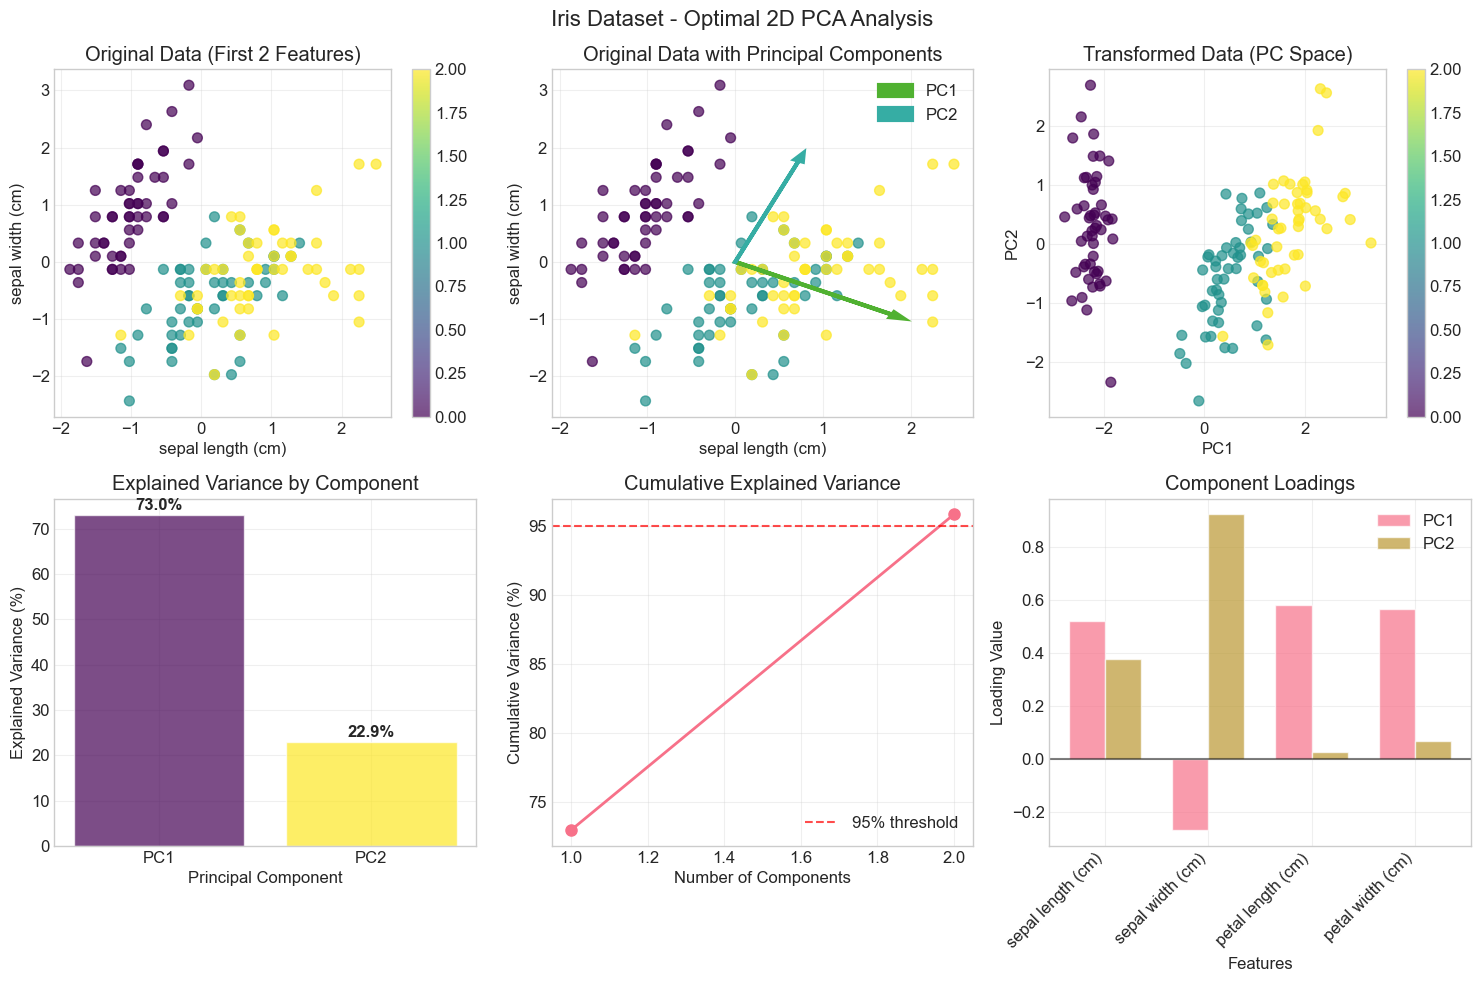

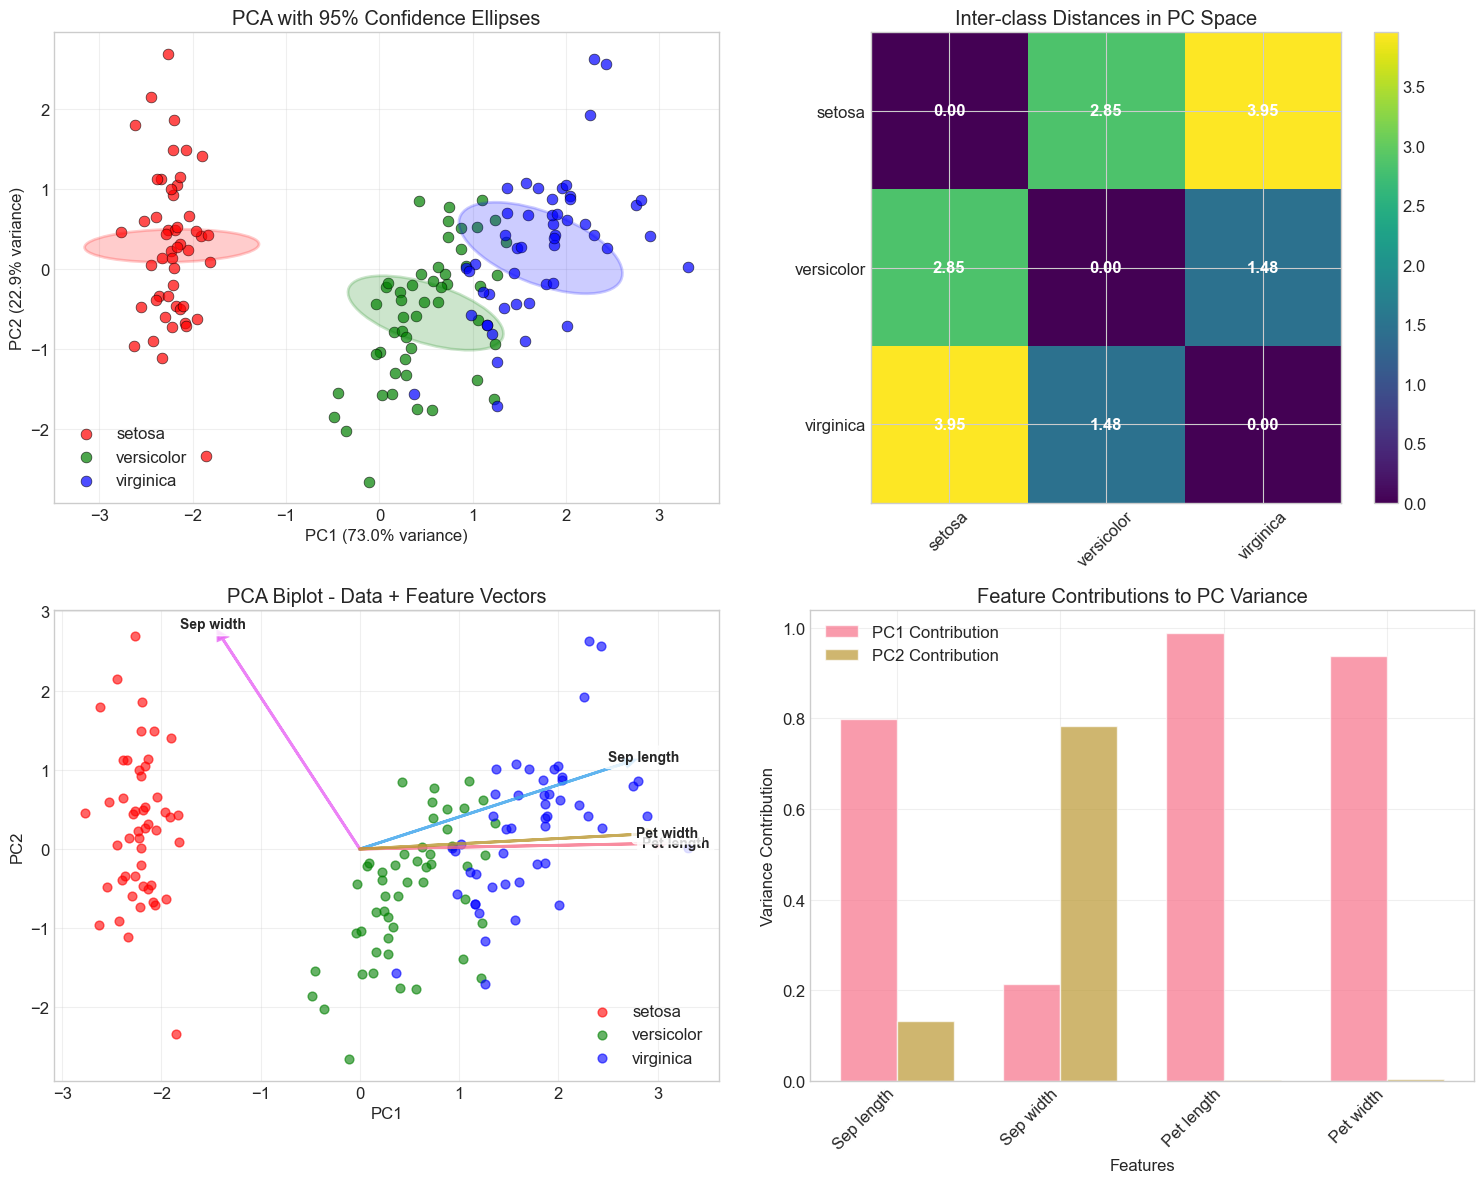


Class Separation Analysis in PC Space:
Setosa vs Versicolor distance: 2.85
Setosa vs Virginica distance: 3.95
Versicolor vs Virginica distance: 1.48

Best separated: Setosa (clearly distinct from others)
Most similar: Versicolor and Virginica


In [15]:
# Create the optimal 2D PCA visualization
pca_2d = PCA(n_components=2)
X_iris_2d = pca_2d.fit_transform(X_iris_scaled)

# Use our visualization utility with enhancements
plot_2d_pca_results(X_iris_scaled, X_iris_2d, pca_2d, labels=y_iris,
                   title="Iris Dataset - Optimal 2D PCA Analysis",
                   feature_names=feature_names)

# Additional detailed 2D analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Enhanced scatter plot with confidence ellipses
colors = ['red', 'green', 'blue']
for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
    class_mask = y_iris == class_idx
    class_data = X_iris_2d[class_mask]

    # Plot points
    axes[0, 0].scatter(class_data[:, 0], class_data[:, 1],
                      c=color, label=class_name, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

    # Add confidence ellipse
    from matplotlib.patches import Ellipse
    mean = np.mean(class_data, axis=0)
    cov = np.cov(class_data.T)
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Calculate ellipse parameters
    angle = np.degrees(np.arctan2(eigenvecs[1, 1], eigenvecs[0, 1]))
    width, height = 2 * np.sqrt(eigenvals)

    ellipse = Ellipse(mean, width, height, angle=angle,
                     facecolor=color, alpha=0.2, edgecolor=color, linewidth=2)
    axes[0, 0].add_patch(ellipse)

axes[0, 0].set_title('PCA with 95% Confidence Ellipses')
axes[0, 0].set_xlabel('PC1 (73.0% variance)')
axes[0, 0].set_ylabel('PC2 (22.9% variance)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Class separation analysis
class_centers = []
for class_idx in range(3):
    class_mask = y_iris == class_idx
    center = np.mean(X_iris_2d[class_mask], axis=0)
    class_centers.append(center)

class_centers = np.array(class_centers)

# Calculate pairwise distances between class centers
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(class_centers))

# Visualize class separation
im = axes[0, 1].imshow(distances, cmap='viridis')
axes[0, 1].set_title('Inter-class Distances in PC Space')
axes[0, 1].set_xticks(range(3))
axes[0, 1].set_yticks(range(3))
axes[0, 1].set_xticklabels(target_names, rotation=45)
axes[0, 1].set_yticklabels(target_names)

# Add distance values
for i in range(3):
    for j in range(3):
        text = axes[0, 1].text(j, i, f'{distances[i, j]:.2f}',
                             ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im, ax=axes[0, 1])

# Feature contribution biplot
# Plot data points
for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
    class_mask = y_iris == class_idx
    axes[1, 0].scatter(X_iris_2d[class_mask, 0], X_iris_2d[class_mask, 1],
                      c=color, label=class_name, alpha=0.6, s=40)

# Add feature vectors (loadings scaled by eigenvalues)
feature_vectors = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
feature_names_short = [name.replace(' (cm)', '').replace('sepal', 'Sep').replace('petal', 'Pet') for name in feature_names]

for i, (feature_name, vector) in enumerate(zip(feature_names_short, feature_vectors)):
    axes[1, 0].arrow(0, 0, vector[0]*3, vector[1]*3,
                    head_width=0.1, head_length=0.1,
                    fc=f'C{i+4}', ec=f'C{i+4}', linewidth=2, alpha=0.8)
    axes[1, 0].text(vector[0]*3.2, vector[1]*3.2, feature_name,
                   fontsize=10, fontweight='bold',
                   ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

axes[1, 0].set_title('PCA Biplot - Data + Feature Vectors')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Variance explained by original features in PC space
feature_variance_pc1 = (pca_2d.components_[0] ** 2) * pca_2d.explained_variance_[0]
feature_variance_pc2 = (pca_2d.components_[1] ** 2) * pca_2d.explained_variance_[1]

x = np.arange(len(feature_names_short))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, feature_variance_pc1, width,
                      label='PC1 Contribution', alpha=0.7, color='C0')
bars2 = axes[1, 1].bar(x + width/2, feature_variance_pc2, width,
                      label='PC2 Contribution', alpha=0.7, color='C1')

axes[1, 1].set_title('Feature Contributions to PC Variance')
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Variance Contribution')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(feature_names_short, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClass Separation Analysis in PC Space:")
print(f"Setosa vs Versicolor distance: {distances[0, 1]:.2f}")
print(f"Setosa vs Virginica distance: {distances[0, 2]:.2f}")
print(f"Versicolor vs Virginica distance: {distances[1, 2]:.2f}")
print(f"\nBest separated: Setosa (clearly distinct from others)")
print(f"Most similar: Versicolor and Virginica")

## Component Loadings Deep Dive

Analysis of each principal component and the meaning in biological terms:

In [16]:
# Detailed component interpretation
print("=" * 60)
print("DETAILED PRINCIPAL COMPONENT INTERPRETATION")
print("=" * 60)

# Component loadings table
loadings_df = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

print("\nComponent Loadings:")
print(loadings_df.round(3))

# Calculate feature importance (squared loadings)
feature_importance_pc1 = pca_2d.components_[0] ** 2
feature_importance_pc2 = pca_2d.components_[1] ** 2

importance_df = pd.DataFrame({
    'PC1_Importance': feature_importance_pc1,
    'PC2_Importance': feature_importance_pc2,
    'Total_Importance': feature_importance_pc1 + feature_importance_pc2
}, index=feature_names)

print("\nFeature Importance (Squared Loadings):")
print(importance_df.round(3))

# Biological interpretation
print("\n" + "=" * 60)
print("BIOLOGICAL INTERPRETATION")
print("=" * 60)

pc1_loadings = pca_2d.components_[0]
pc2_loadings = pca_2d.components_[1]

print(f"\nPC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance):")
print(f"  Loadings: {dict(zip(feature_names_short, pc1_loadings.round(3)))}")
if np.all(pc1_loadings > 0):
    print(f"  → OVERALL FLOWER SIZE: All measurements contribute positively")
    print(f"  → Larger flowers have higher PC1 scores")
    print(f"  → This represents the primary axis of morphological variation")
else:
    print(f"  → CONTRAST between different flower parts")

print(f"\nPC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance):")
print(f"  Loadings: {dict(zip(feature_names_short, pc2_loadings.round(3)))}")

# Analyze PC2 pattern
sepal_avg = np.mean([pc2_loadings[0], pc2_loadings[1]])  # sepal length, width
petal_avg = np.mean([pc2_loadings[2], pc2_loadings[3]])  # petal length, width

if sepal_avg * petal_avg < 0:  # Opposite signs
    print(f"  → SEPAL vs PETAL CONTRAST: Sepals and petals vary inversely")
    if sepal_avg > 0:
        print(f"  → High PC2: Large sepals, small petals")
        print(f"  → Low PC2: Small sepals, large petals")
    else:
        print(f"  → High PC2: Small sepals, large petals")
        print(f"  → Low PC2: Large sepals, small petals")
else:
    length_avg = np.mean([pc2_loadings[0], pc2_loadings[2]])  # lengths
    width_avg = np.mean([pc2_loadings[1], pc2_loadings[3]])   # widths

    if length_avg * width_avg < 0:
        print(f"  → LENGTH vs WIDTH CONTRAST: Shape variation")
        if length_avg > 0:
            print(f"  → High PC2: Long, narrow flowers")
            print(f"  → Low PC2: Short, wide flowers")
        else:
            print(f"  → High PC2: Short, wide flowers")
            print(f"  → Low PC2: Long, narrow flowers")

# Species characterization in PC space
print(f"\n" + "=" * 60)
print("SPECIES CHARACTERIZATION IN PC SPACE")
print("=" * 60)

for class_idx, class_name in enumerate(target_names):
    class_mask = y_iris == class_idx
    class_pc1_mean = np.mean(X_iris_2d[class_mask, 0])
    class_pc2_mean = np.mean(X_iris_2d[class_mask, 1])

    print(f"\n{class_name.upper()}:")
    print(f"  PC1 mean: {class_pc1_mean:.2f} (size: {'large' if class_pc1_mean > 0 else 'small'})")
    print(f"  PC2 mean: {class_pc2_mean:.2f}")

    # Characterize based on PC2
    if class_pc2_mean > 0.5:
        pc2_char = "high PC2 - distinctive shape pattern"
    elif class_pc2_mean < -0.5:
        pc2_char = "low PC2 - opposite shape pattern"
    else:
        pc2_char = "moderate PC2 - intermediate shape"

    print(f"  Shape: {pc2_char}")

    # Original feature means for context
    class_features = X_iris[class_mask]
    feature_means = np.mean(class_features, axis=0)
    print(f"  Original features: {dict(zip(feature_names_short, feature_means.round(2)))}")

DETAILED PRINCIPAL COMPONENT INTERPRETATION

Component Loadings:
                     PC1    PC2
sepal length (cm)  0.521  0.377
sepal width (cm)  -0.269  0.923
petal length (cm)  0.580  0.024
petal width (cm)   0.565  0.067

Feature Importance (Squared Loadings):
                   PC1_Importance  PC2_Importance  Total_Importance
sepal length (cm)           0.272           0.142             0.414
sepal width (cm)            0.073           0.852             0.925
petal length (cm)           0.337           0.001             0.337
petal width (cm)            0.319           0.004             0.324

BIOLOGICAL INTERPRETATION

PC1 (73.0% variance):
  Loadings: {'Sep length': np.float64(0.521), 'Sep width': np.float64(-0.269), 'Pet length': np.float64(0.58), 'Pet width': np.float64(0.565)}
  → CONTRAST between different flower parts

PC2 (22.9% variance):
  Loadings: {'Sep length': np.float64(0.377), 'Sep width': np.float64(0.923), 'Pet length': np.float64(0.024), 'Pet width': np.float64(

In [17]:
# Save results for later use
iris_results = {
    'pca_model': pca_2d,
    'transformed_data': X_iris_2d,
    'original_data': X_iris_scaled,
    'labels': y_iris,
    'explained_variance_ratio': pca_2d.explained_variance_ratio_,
    'feature_names': feature_names,
    'target_names': target_names
}

# Save to processed data directory
import pickle
with open('../data/processed/iris_pca_results.pkl', 'wb') as f:
    pickle.dump(iris_results, f)

print("✅ Iris PCA analysis complete!")
print(f"📊 Results saved to ../data/processed/iris_pca_results.pkl")
print(f"🎯 Key finding: First 2 PCs explain {(pca_2d.explained_variance_ratio_[0] + pca_2d.explained_variance_ratio_[1])*100:.1f}% of variance")
print(f"🔍 PC1 represents overall flower size, PC2 represents shape contrasts")
print(f"🌸 Setosa is clearly separated, while Versicolor and Virginica show some overlap")

✅ Iris PCA analysis complete!
📊 Results saved to ../data/processed/iris_pca_results.pkl
🎯 Key finding: First 2 PCs explain 95.8% of variance
🔍 PC1 represents overall flower size, PC2 represents shape contrasts
🌸 Setosa is clearly separated, while Versicolor and Virginica show some overlap
